In [17]:
import pickle
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score


In [33]:
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)
print(data[0][0])
random.seed(1)
random.shuffle(data)
train_data, test_data = train_test_split(data, test_size=0.2)
print(len(data))
print(len(train_data))
print(len(test_data))
print(len(data[0][0]))
print(data[0][0])

[33.         26.          5.         60.         22.         59.
  8.         21.         11.          7.66666667  1.3662601   7.
  4.        ]
6528
5222
1306
13
[23.         15.          2.         57.         17.         50.
  1.         12.         11.          8.75        3.19597962  8.
  6.        ]


In [19]:
def create_tensors(data_list):
    # create tensor that is compatible to load and train in the language model
    ds = {}
    keys = ['skills','subtests','questions','answers','y']
    for key in keys:
        ds[key] = []
    
    for entry in data_list:
        ds['skills'].append(entry[0])
        ds['subtests'].append(entry[1])
        ds['questions'].append(entry[2])
        ds['answers'].append(entry[3])
        ds['y'].append(entry[4])
    
    ds['skills'] = torch.tensor(ds['skills']).type(torch.float)
    ds['subtests'] = torch.tensor(ds['subtests'])
    ds['questions'] = torch.tensor(ds['questions'])
    ds['answers'] = torch.tensor(ds['answers'])
    ds['y'] = torch.tensor(ds['y']).type(torch.float)

    return ds

In [37]:
class BertModel(nn.Module):
    def __init__(self, sentence_dim, skill_dim, dropout):
        super().__init__()
        self.skill_dim = skill_dim
        self.fc_test = nn.Linear(768,sentence_dim)
        self.fc_question = nn.Linear(768,sentence_dim)
        self.fc_answer = nn.Linear(768,sentence_dim)
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(3*sentence_dim+skill_dim*2,128)
        self.out = nn.Linear(128,1)
    
    def forward(self, skills,test,question,answer):
        x1 = self.fc_skill(skills[:,:skill_dim])
        x2 = self.fc_test(test)
        x3 = self.fc_question(question)
        x4 = self.fc_answer(answer)
        x = torch.cat((x1,x2,x3,x4),dim=1)
        x = self.fc2(self.relu(x))
        pred = self.out(self.relu(x))
        
        return pred

In [21]:
class SimpleNet(nn.Module):
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,128)
        self.out = nn.Linear(128,1)
        
    def forward(self, skills):
        x1 = self.fc_skill(skills)
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [22]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [23]:
def confusion_matrix(preds, Y):
    rounded_preds = torch.round(preds.sigmoid())
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i, value in enumerate(rounded_preds):
        if value == Y[i] and value == 1:
            TP += 1
        elif value == Y[i] and value == 0:
            TN += 1
        elif value != Y[i] and value == 0:
            FN += 1
        elif value != Y[i] and value == 1:
            FP += 1
        else:
            print(value,Y[i])
    print(f'TP: {TP}\tFN: {FN}')
    print(f'FP: {FP}\tTN: {TN}')

In [24]:

def precision(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
#     print((rounded_preds==1).sum())
#     print((y==1).sum())
    return precision_score(y,rounded_preds)

def recall(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
    return recall_score(y,rounded_preds)
    

In [25]:
def train(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills'],data['subtests'],data['questions'],data['answers']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 


In [26]:
def evaluate(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills'],data['subtests'],data['questions'],data['answers']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [70]:
max_epochs = 225
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 32
skill_dim = 13
dropout = 0.1

net = BertModel(sentence_dim, skill_dim, dropout)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

f1_max = [0,0]
for epoch in range(max_epochs):
    train_loss, train_acc = train(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            f1 = 2*(prec*rec)/(prec+rec)
            print(f"f1 = {f1}")
            if f1 > f1_max[0]:
                f1_max[0] = f1
                f1_max[1] = epoch
        except:
            continue

Epoch: 0
TP: 471	FN: 244
FP: 274	TN: 317
	Train Loss: 0.789 | Train Acc: 45.31%
	 Val. Loss: 0.678 |  Val. Acc: 60.34%
precision:  0.6322147651006711
recall:  0.6587412587412588
f1 = 0.6452054794520549
Epoch: 25
TP: 579	FN: 136
FP: 306	TN: 285
	Train Loss: 0.608 | Train Acc: 67.12%
	 Val. Loss: 0.616 |  Val. Acc: 66.16%
precision:  0.6542372881355932
recall:  0.8097902097902098
f1 = 0.72375
Epoch: 50
TP: 541	FN: 174
FP: 242	TN: 349
	Train Loss: 0.580 | Train Acc: 69.92%
	 Val. Loss: 0.592 |  Val. Acc: 68.15%
precision:  0.6909323116219668
recall:  0.7566433566433567
f1 = 0.7222963951935913
Epoch: 75
TP: 539	FN: 176
FP: 228	TN: 363
	Train Loss: 0.572 | Train Acc: 70.89%
	 Val. Loss: 0.582 |  Val. Acc: 69.07%
precision:  0.7027379400260756
recall:  0.7538461538461538
f1 = 0.7273954116059379
Epoch: 100
TP: 538	FN: 177
FP: 222	TN: 369
	Train Loss: 0.567 | Train Acc: 71.22%
	 Val. Loss: 0.577 |  Val. Acc: 69.45%
precision:  0.7078947368421052
recall:  0.7524475524475525
f1 = 0.7294915254237

In [71]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(net)
test_ds['skills'].requires_grad_()
test_ds['subtests'].requires_grad_()
test_ds['questions'].requires_grad_()
test_ds['answers'].requires_grad_()


attr,delta = ig.attribute((test_ds['skills'],test_ds['subtests'],test_ds['questions'],test_ds['answers'])\
                          ,return_convergence_delta=True)


In [72]:
attr = attr[0].detach().numpy()
print(attr)

[[-0.09100521 -1.35675336  1.00882048 ... -0.20774259 -1.48116237
  -0.75076864]
 [ 0.83759693 -0.34807344  0.28158192 ... -0.0823799   0.30513513
  -0.22725153]
 [-0.12756444 -1.06079944  1.61869643 ... -0.16927518 -1.21478559
  -1.38917139]
 ...
 [ 0.61455439 -1.02378127  1.03882422 ... -0.16039462 -0.78013361
  -0.75481036]
 [-0.08697633 -1.5277641   1.45363305 ... -0.35638056 -1.18183722
  -1.56512035]
 [-0.57473597 -0.64854992  1.03812929 ... -0.11281245 -0.75089058
  -0.62315688]]


Average Feature Importances
G3.PPVT.Vocab.raw :  0.513
G3.Elision.PA.raw :  -0.944
G3.Syn.GramCorrect.raw :  1.069
G3.TOWRE.SWE.raw :  1.085
G3.TOWRE.PDE.raw :  0.288
G3.WordID.raw :  2.885
G3.OL.Spell.Total :  0.236
G3.OL.OrthoChoice.1.2.Total :  -0.080
G3.DigitSpan.raw :  -0.009
text_depth_avg :  -0.707
text_depth_stdev :  -0.232
question_depth :  -0.855
answer_depth :  -0.771


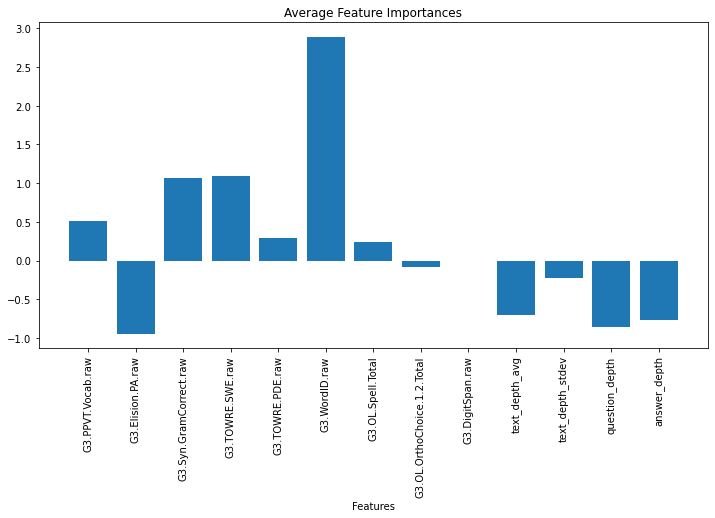

In [77]:

# attr = attr[0].detach().numpy()
from matplotlib import pyplot as plt

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, rotation='vertical')
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names+['text_depth_avg','text_depth_stdev','question_depth','answer_depth',], np.mean(attr, axis=0))

In [48]:
print(f1_max)

[0.7531772575250838, 275]


In [54]:
max_epochs = 400
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 32
skill_dim = 9
dropout = 0.1

net = BertModel(sentence_dim, skill_dim, dropout)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

f1_max = [0,0]
for epoch in range(max_epochs):
    train_loss, train_acc = train(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            f1 = 2*(prec*rec)/(prec+rec)
            print(f"f1 = {f1}")
            if f1 > f1_max[0]:
                f1_max[0] = f1
                f1_max[1] = epoch
        except:
            continue

Epoch: 0
TP: 715	FN: 0
FP: 591	TN: 0
	Train Loss: 0.692 | Train Acc: 54.60%
	 Val. Loss: 0.679 |  Val. Acc: 54.75%
precision:  0.5474732006125574
recall:  1.0
f1 = 0.7075705096486888
Epoch: 25
TP: 536	FN: 179
FP: 247	TN: 344
	Train Loss: 0.588 | Train Acc: 69.15%
	 Val. Loss: 0.601 |  Val. Acc: 67.38%
precision:  0.6845466155810983
recall:  0.7496503496503496
f1 = 0.7156208277703604
Epoch: 50
TP: 541	FN: 174
FP: 235	TN: 356
	Train Loss: 0.577 | Train Acc: 70.28%
	 Val. Loss: 0.588 |  Val. Acc: 68.68%
precision:  0.6971649484536082
recall:  0.7566433566433567
f1 = 0.7256874580818242
Epoch: 75
TP: 538	FN: 177
FP: 228	TN: 363
	Train Loss: 0.570 | Train Acc: 70.64%
	 Val. Loss: 0.583 |  Val. Acc: 68.99%
precision:  0.7023498694516971
recall:  0.7524475524475525
f1 = 0.7265361242403782
Epoch: 100
TP: 536	FN: 179
FP: 222	TN: 369
	Train Loss: 0.563 | Train Acc: 70.97%
	 Val. Loss: 0.579 |  Val. Acc: 69.30%
precision:  0.7071240105540897
recall:  0.7496503496503496
f1 = 0.7277664630006788
Epoc

In [55]:
print(f1_max)

[0.7427413909520595, 225]


In [28]:
feature_names = ['G3.PPVT.Vocab.raw',
                 'G3.Elision.PA.raw',
                 'G3.Syn.GramCorrect.raw',
                 'G3.TOWRE.SWE.raw',
                 'G3.TOWRE.PDE.raw',
                 'G3.WordID.raw',
                 'G3.OL.Spell.Total',
                 'G3.OL.OrthoChoice.1.2.Total',
                 'G3.DigitSpan.raw',]

In [29]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(train_ds['skills'], mode="regression", feature_names=feature_names)

TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


### Simple NN model without text embeddings

In [30]:
def train_simple(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 

In [31]:
def evaluate_simple(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [32]:
max_epochs = 400
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 128
skill_dim = 10
dropout = 0.1

net = SimpleNet(skill_dim)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

for epoch in range(max_epochs):
    train_loss, train_acc = train_simple(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate_simple(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            print(f"f1 = {2*(prec*rec)/(prec+rec)}")
        except:
            continue

Epoch: 0
TP: 8	FN: 730
FP: 21	TN: 547
	Train Loss: 1.093 | Train Acc: 45.40%
	 Val. Loss: 0.839 |  Val. Acc: 42.50%
precision:  0.27586206896551724
recall:  0.01084010840108401
f1 = 0.020860495436766623
Epoch: 25
TP: 620	FN: 118
FP: 324	TN: 244
	Train Loss: 0.649 | Train Acc: 61.05%
	 Val. Loss: 0.625 |  Val. Acc: 66.16%
precision:  0.6567796610169492
recall:  0.8401084010840109
f1 = 0.7372175980975029
Epoch: 50
TP: 593	FN: 145
FP: 277	TN: 291
	Train Loss: 0.634 | Train Acc: 64.29%
	 Val. Loss: 0.611 |  Val. Acc: 67.69%
precision:  0.6816091954022988
recall:  0.8035230352303523
f1 = 0.7375621890547263
Epoch: 75
TP: 555	FN: 183
FP: 237	TN: 331
	Train Loss: 0.625 | Train Acc: 65.47%
	 Val. Loss: 0.609 |  Val. Acc: 67.84%
precision:  0.7007575757575758
recall:  0.7520325203252033
f1 = 0.7254901960784315
Epoch: 100
TP: 568	FN: 170
FP: 242	TN: 326
	Train Loss: 0.616 | Train Acc: 66.60%
	 Val. Loss: 0.602 |  Val. Acc: 68.45%
precision:  0.7012345679012346
recall:  0.7696476964769647
f1 = 0.7